In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pathlib
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models import *
from utils import *
from preprocessing import *

from loguru import logger
from sklearn.linear_model import TweedieRegressor

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

NVIDIA GeForce GTX 1080


In [2]:
parent_path = Path('./data/biological/')
save_path = Path('./save/trained_models/')
EB095_stim_path = parent_path / 'EB095/EB095_stim/'
JAN23_stim_path = parent_path / 'JAN23/'

EB095_dff_stim = np.load(EB095_stim_path /'dff_stim.npy')                  # (294, 94696) GCaMP when stimulated 
EB095_spks_stim = np.load(EB095_stim_path /'spks_stim.npy')                # (106, 94096)
EB095_area_ID = np.load(EB095_stim_path /'area_ID_ephys.npy')

EB095_stim_ID = np.load(EB095_stim_path /'stim_ID.npy')
EB095_stim_ID_resolved = np.load(EB095_stim_path /'stim_ID_resolved.npy')  # (300, 6), R S or F
EB095_stim_time = np.load(EB095_stim_path /'stim_triggers.npy')            # (300, )

JAN23_stim_time = np.load(JAN23_stim_path / 'stim_times.npy')              # (300,)
JAN23_spks_stim = np.load(JAN23_stim_path / 'ephys_array.npy')           # (77, 94357)
JAN23_dff_stim = np.load(JAN23_stim_path / 'img_array.npy')               # (384, 94357)
JAN23_stim_id = np.load(JAN23_stim_path / 'stim_ID.npy')                   # (300,)

2024-03-13 12:46:22.594 | INFO     | preprocessing:convolve_spikes:26 - Detected Ephys file with 77 neurons and 94357 bins.
2024-03-13 12:46:22.755 | INFO     | preprocessing:convolve_spikes:51 - Produced convolved rates at sigma=0.1 with 77 neurons and 94357 bins.


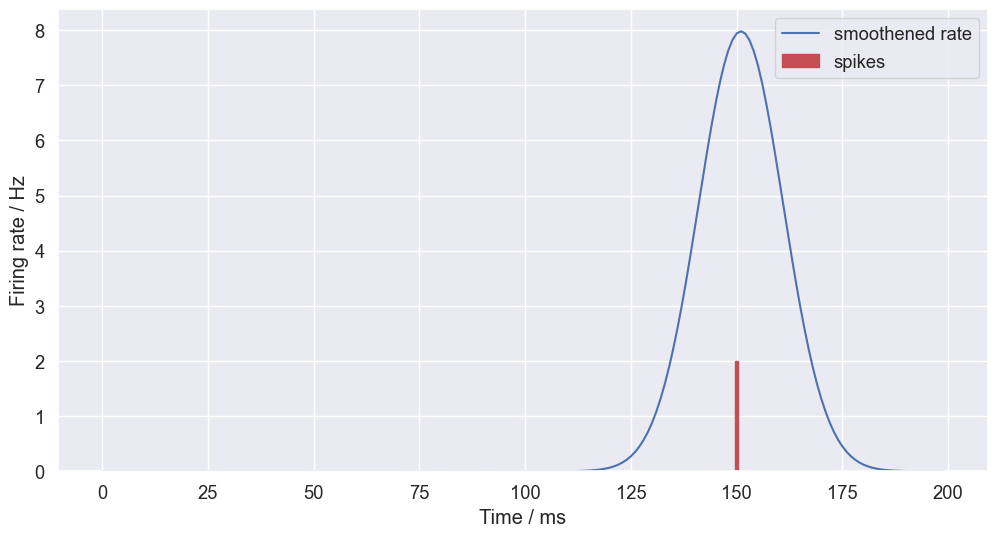

In [3]:
# load JAN23 data

JAN23_spks_stim_rates, JAN23_n_output_neurons, JAN23_n_bins = convolve_spikes(JAN23_spks_stim)
plot_convolution_example(JAN23_spks_stim_rates, JAN23_spks_stim)
JAN23_input_dim = JAN23_dff_stim.shape[0]
JAN23_n_LS_neurons = 13
assert JAN23_n_bins == JAN23_dff_stim.shape[1]

2024-03-13 12:46:23.019 | INFO     | preprocessing:convolve_spikes:26 - Detected Ephys file with 106 neurons and 94696 bins.
2024-03-13 12:46:23.185 | INFO     | preprocessing:convolve_spikes:51 - Produced convolved rates at sigma=0.1 with 106 neurons and 94696 bins.


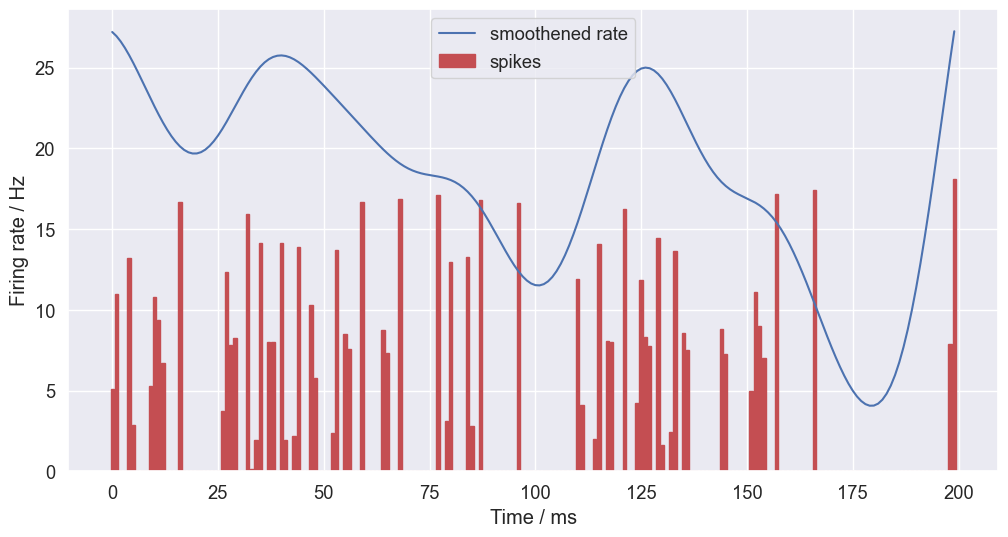

In [4]:
# load EB095 data
EB095_spks_stim_rates, EB095_n_output_neurons, EB095_n_bins = convolve_spikes(EB095_spks_stim)
EB095_n_LS_neurons = np.sum(EB095_area_ID == 'LS')
EB095_LS_neuron_idx = np.where(EB095_area_ID == 'LS')[0]
plot_convolution_example(EB095_spks_stim_rates, EB095_spks_stim,seed=seed)
EB095_input_dim = EB095_dff_stim.shape[0]
assert EB095_n_bins == EB095_dff_stim.shape[1]

### Using EB095-learned Transformer to learn JAN23 Data

In [7]:
# load trained model
d_model = 304
num_heads = 19
hidden_dim = 948
n_layers = 4

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model % 2 != 0:
    d_model += num_heads

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep

DNN_LS = TransformerOneStep(EB095_input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=EB095_n_LS_neurons,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                decoder='linear',
                decoder_hidden_dim=None,
                use_mask=False,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)


with open(save_path / f'EB095/EB095-stim-LS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}.pkl', 'rb') as f:
    EB095_metadata = pickle.load(f)
best_eval_params = torch.load(save_path /f'EB095/EB095-stim-LS-transformer-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}.pth')
DNN_LS.load_state_dict(best_eval_params)

c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [6]:
EB095_encoder_params_dict, EB095_non_encoder_params_dict = DNN_LS.get_separate_params()

In [7]:
inputs, targets, non_stim_vecs_idx, stim_vecs_idx = preprocess_dff_rate_pairs(JAN23_dff_stim,
                                                                              JAN23_spks_stim_rates,
                                                                              has_stim=True,
                                                                              stim_time=JAN23_stim_time,
                                                                              stim_ID=JAN23_stim_id,
                                                                              cutoff_size=1,
                                                                              offset=-3,
                                                                              tsteps=15)
sampled_non_stim_vecs = sample_non_stim_vecs(non_stim_vecs_idx, cutoff_size=1, n=200, seed=seed)

batch_size = 512
JAN23_LS_neuron_idx = np.arange(13) # first 13 neurons are LS
test_set_idx = np.concatenate([stim_vecs_idx, sampled_non_stim_vecs])
X, Y = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
valid_idx = np.random.choice(np.arange(len(Y)), int(len(Y) * 0.10))
train_idx = np.array(list((set(np.arange(len(Y))) - set(valid_idx))))
X_test, Y_test_LS, Y_test_nLS = inputs[test_set_idx], targets[test_set_idx][..., JAN23_LS_neuron_idx], targets[test_set_idx][..., 13:]

X_train, Y_train_LS = X[train_idx, ...], Y[train_idx,:,:][..., JAN23_LS_neuron_idx]

JAN23_train_dataset = BNN_Dataset(X_train, Y_train_LS)
JAN23_train_loader_LS = DataLoader(JAN23_train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
JAN23_test_dataset = BNN_Dataset(X_test, Y_test_LS)
JAN23_test_loader_LS = DataLoader(JAN23_test_dataset, batch_size=len(JAN23_train_dataset), drop_last=False, shuffle=False)

del JAN23_train_dataset, JAN23_test_dataset

forward_mse_idx = list(np.nonzero(np.array(JAN23_stim_id) == 'a')[0])
backward_mse_idx = list(np.nonzero(np.array(JAN23_stim_id) == 'b')[0])
random_mse_idx = list(np.nonzero(np.array(JAN23_stim_id) == 'c')[0])
non_stim_mse_idx = np.arange(len(JAN23_stim_id), Y_test_LS.shape[0])

In [8]:
# try 1: freeze encoder weights
DNN_LS.prepare_for_transfer_learning(new_input_dim=JAN23_input_dim,
                                     new_output_dim=JAN23_n_LS_neurons,
                                     freeze_weights=True)

Encoder Weights are frozen.
Using a linear decoder, decoder hidden dim will be reset to 0.
Reinitialised input and output layers with 384 input units and 13 output units.


In [9]:
return_dict = None # intialise as None
n_cycles = 1
num_epochs = 500

from train import train_transformer, eval_transformer

for c in range(n_cycles):

    optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.MSELoss(reduction='none')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                        mode='min', 
                                                        factor=0.5, 
                                                        patience=10, 
                                                        threshold=0.01)

    return_dict = train_transformer(
                model=DNN_LS,
                train_loader=JAN23_train_loader_LS,
                test_loader=JAN23_test_loader_LS,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=True,
                batch_first=True,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices=
                [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx],
                prev_return_dict=return_dict)

Initial eval loss: 1269.2313433520071


  0%|          | 1/500 [00:00<06:14,  1.33it/s]

Epoch 1: training loss 1180.5441772460938, eval loss 1095.927886883329. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:32,  1.43it/s]

Epoch 26: training loss 184.22628479003907, eval loss 212.94473278524723. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:35<05:10,  1.45it/s]

Epoch 51: training loss 140.0266326904297, eval loss 202.9560561525932. Time elapsed: 0 h 0 m 35 s.


 15%|█▌        | 76/500 [00:52<04:54,  1.44it/s]

Epoch 76: training loss 123.43469543457032, eval loss 198.2063318456988. Time elapsed: 0 h 0 m 53 s.


 20%|██        | 101/500 [01:10<04:45,  1.40it/s]

Epoch 101: training loss 119.85032958984375, eval loss 197.99589068253164. Time elapsed: 0 h 1 m 10 s.


 25%|██▌       | 126/500 [01:28<04:20,  1.43it/s]

Epoch 126: training loss 120.36018295288086, eval loss 197.49985238200156. Time elapsed: 0 h 1 m 28 s.


 30%|███       | 151/500 [01:45<04:00,  1.45it/s]

Epoch 151: training loss 119.38214492797852, eval loss 197.53255215410493. Time elapsed: 0 h 1 m 45 s.


 32%|███▏      | 158/500 [01:51<04:00,  1.42it/s]


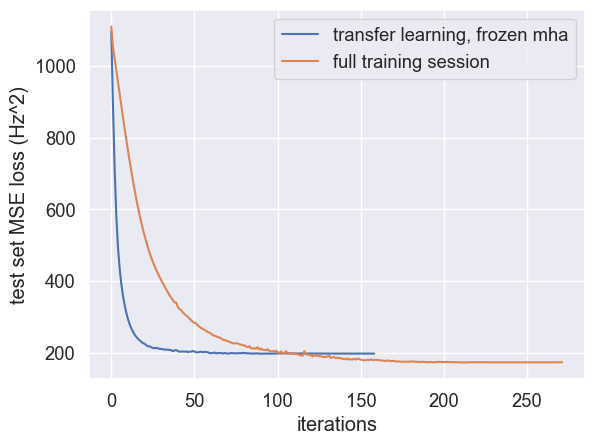

In [10]:
plt.plot(return_dict['eval_losses'], label='transfer learning, frozen mha')

# original training curve
with open(f'./save/trained_models/JAN23/JAN23-stim-LS-transformer-param-metadata-432-16-446-3-trained-1.pkl', 'rb') as f:
    original_return_dict = pickle.load(f)

plt.plot(original_return_dict['return_dict']['eval_losses'], label='full training session')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('test set MSE loss (Hz^2)')
plt.show()

In [19]:
# try 2: do not freeze encoder weights
DNN_LS.unfreeze_weights()
DNN_LS.prepare_for_transfer_learning(new_input_dim=JAN23_input_dim,
                                     new_output_dim=JAN23_n_LS_neurons,
                                     freeze_weights=False)

All Weights are unfrozen.
All Weights are unfrozen.
Using a linear decoder, decoder hidden dim will be reset to 0.
Reinitialised input and output layers with 384 input units and 13 output units.


In [20]:
return_dict = None # intialise as None
n_cycles = 1
num_epochs = 500

from train import train_transformer, eval_transformer

for c in range(n_cycles):

    optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.MSELoss(reduction='none')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                        mode='min', 
                                                        factor=0.5, 
                                                        patience=10, 
                                                        threshold=0.01)

    return_dict = train_transformer(
                model=DNN_LS,
                train_loader=JAN23_train_loader_LS,
                test_loader=JAN23_test_loader_LS,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=True,
                batch_first=True,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices=
                [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx],
                prev_return_dict=return_dict)

Initial eval loss: 1274.3436971351202


  0%|          | 1/500 [00:01<08:20,  1.00s/it]

Epoch 1: training loss 1054.8917175292968, eval loss 932.1426011860285. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:22<06:52,  1.15it/s]

Epoch 26: training loss 139.9096481323242, eval loss 188.59561861341933. Time elapsed: 0 h 0 m 23 s.


 10%|█         | 51/500 [00:44<06:26,  1.16it/s]

Epoch 51: training loss 69.30217514038085, eval loss 169.8258850299532. Time elapsed: 0 h 0 m 44 s.


 15%|█▌        | 76/500 [01:06<06:08,  1.15it/s]

Epoch 76: training loss 36.16875, eval loss 173.43135682168065. Time elapsed: 0 h 1 m 6 s.


 20%|██        | 101/500 [01:28<05:49,  1.14it/s]

Epoch 101: training loss 30.088459014892578, eval loss 174.8372613545594. Time elapsed: 0 h 1 m 28 s.


 25%|██▌       | 126/500 [01:49<05:26,  1.15it/s]

Epoch 126: training loss 28.83591232299805, eval loss 173.21622718040558. Time elapsed: 0 h 1 m 50 s.


 30%|███       | 151/500 [02:11<05:02,  1.16it/s]

Epoch 151: training loss 28.381859016418456, eval loss 173.68586757578873. Time elapsed: 0 h 2 m 11 s.


 32%|███▏      | 159/500 [02:19<04:59,  1.14it/s]


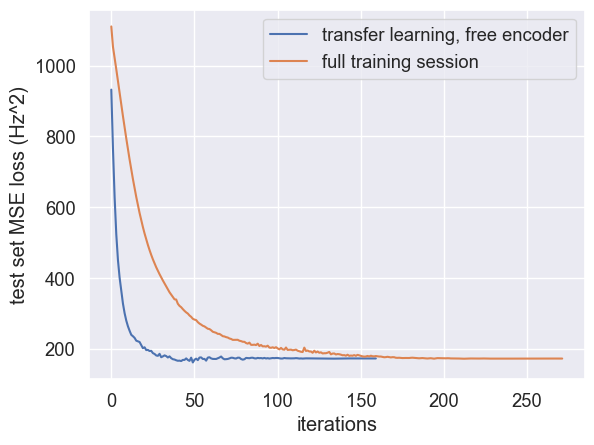

In [21]:
plt.plot(return_dict['eval_losses'], label='transfer learning, free encoder')

# original training curve
with open(f'./save/trained_models/JAN23/JAN23-stim-LS-transformer-param-metadata-432-16-446-3-trained-1.pkl', 'rb') as f:
    original_return_dict = pickle.load(f)

plt.plot(original_return_dict['return_dict']['eval_losses'], label='full training session')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('test set MSE loss (Hz^2)')
plt.show()

In [22]:
encoder_params_dict, JAN23_non_encoder_params_dict = DNN_LS.get_separate_params()

### Using JAN23 learned Transformer to learn EB095 Data

In [16]:
# load trained model
d_model = 432
num_heads = 16
hidden_dim = 446
n_layers = 3

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model % 2 != 0:
    d_model += num_heads

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep

DNN_LS = TransformerOneStep(JAN23_input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=JAN23_n_LS_neurons,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                decoder='linear',
                decoder_hidden_dim=None,
                use_mask=False,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)


with open(save_path / f"JAN23/JAN23-stim-LS-transformer-param-metadata-432-16-446-3-trained-25.pkl", 'rb') as f:
    JAN23_metadata = pickle.load(f)
DNN_LS.load_state_dict(torch.load(save_path / f"JAN23/JAN23-stim-LS-transformer-param-432-16-446-3-trained-25.pth"))

c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [6]:
JAN23_encoder_params_dict, JAN23_non_encoder_params_dict = DNN_LS.get_separate_params()

In [7]:
inputs, targets, non_stim_vecs_idx, stim_vecs_idx = preprocess_dff_rate_pairs(EB095_dff_stim,
                                                                              EB095_spks_stim_rates,
                                                                              has_stim=True,
                                                                              stim_time=EB095_stim_time,
                                                                              stim_ID=EB095_stim_ID,
                                                                              cutoff_size=1,
                                                                              offset=-3,
                                                                              tsteps=15)
sampled_non_stim_vecs = sample_non_stim_vecs(non_stim_vecs_idx, cutoff_size=1, n=200, seed=seed)

batch_size = 512
test_set_idx = np.concatenate([stim_vecs_idx, sampled_non_stim_vecs])
X, Y = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
valid_idx = np.random.choice(np.arange(len(Y)), int(len(Y) * 0.10))
train_idx = np.array(list((set(np.arange(len(Y))) - set(valid_idx))))
X_test, Y_test_LS = inputs[test_set_idx], targets[test_set_idx][..., EB095_LS_neuron_idx]

X_train, Y_train_LS = X[train_idx, ...], Y[train_idx,:,:][..., EB095_LS_neuron_idx]

EB095_train_dataset = BNN_Dataset(X_train, Y_train_LS)
EB095_train_loader_LS = DataLoader(EB095_train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
EB095_test_dataset = BNN_Dataset(X_test, Y_test_LS)
EB095_test_loader_LS = DataLoader(EB095_test_dataset, batch_size=len(EB095_train_dataset), drop_last=False, shuffle=False)

del EB095_train_dataset, EB095_test_dataset

forward_mse_idx = list(np.nonzero(np.array(EB095_stim_ID) == 'a')[0])
backward_mse_idx = list(np.nonzero(np.array(EB095_stim_ID) == 'b')[0])
random_mse_idx = list(np.nonzero(np.array(EB095_stim_ID) == 'c')[0])
non_stim_mse_idx = np.arange(len(EB095_stim_ID), Y_test_LS.shape[0])

In [8]:
# try 1: freeze encoder weights
DNN_LS.prepare_for_transfer_learning(new_input_dim=EB095_input_dim,
                                     new_output_dim=EB095_n_LS_neurons,
                                     freeze_weights=True)

Encoder Weights are frozen.
Using a linear decoder, decoder hidden dim will be reset to 0.
Reinitialised input and output layers with 294 input units and 8 output units.


In [9]:
return_dict = None # intialise as None
n_cycles = 1
num_epochs = 500

from train import train_transformer, eval_transformer

for c in range(n_cycles):

    optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.MSELoss(reduction='none')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                        mode='min', 
                                                        factor=0.5, 
                                                        patience=10, 
                                                        threshold=0.01)

    return_dict = train_transformer(
                model=DNN_LS,
                train_loader=EB095_train_loader_LS,
                test_loader=EB095_test_loader_LS,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=True,
                batch_first=True,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices=
                [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx],
                prev_return_dict=return_dict)

Initial eval loss: 1100.7287806516129


  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\Dan\Documents\Barry Lab\approx_brain\train.py:321: RuntimeWarning: invalid value encountered in scalar divide
  eval_losses_by_type[i].append(eval_loss[0, type_idx].sum()/Y.shape[-1]/len(type_idx))
  0%|          | 1/500 [00:00<05:23,  1.54it/s]

Epoch 1: training loss 926.4462463378907, eval loss 890.9820382637831. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:15<04:45,  1.66it/s]

Epoch 26: training loss 138.2753921508789, eval loss 167.35813881179328. Time elapsed: 0 h 0 m 15 s.


 10%|█         | 51/500 [00:30<04:25,  1.69it/s]

Epoch 51: training loss 79.98207550048828, eval loss 158.48084642503864. Time elapsed: 0 h 0 m 30 s.


 15%|█▌        | 76/500 [00:45<04:12,  1.68it/s]

Epoch 76: training loss 65.3290843963623, eval loss 159.67977067196625. Time elapsed: 0 h 0 m 45 s.


 20%|██        | 101/500 [00:59<03:59,  1.67it/s]

Epoch 101: training loss 64.68685035705566, eval loss 161.31085515084868. Time elapsed: 0 h 1 m 0 s.


 25%|██▌       | 126/500 [01:14<03:40,  1.69it/s]

Epoch 126: training loss 63.97385787963867, eval loss 161.54337743462014. Time elapsed: 0 h 1 m 14 s.


 30%|██▉       | 148/500 [01:28<03:30,  1.68it/s]


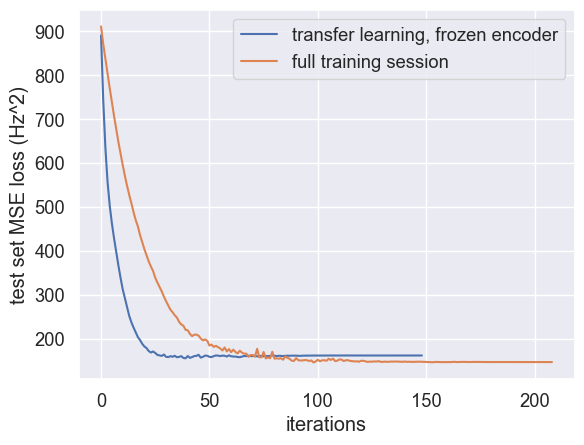

In [12]:
plt.plot(return_dict['eval_losses'], label='transfer learning, frozen encoder')

# original training curve
with open(f'./save/trained_models/EB095/EB095-stim-LS-transformer-param-metadata-304-19-948-4-trained-1.pkl', 'rb') as f:
    original_return_dict = pickle.load(f)

plt.plot(original_return_dict['return_dict']['eval_losses'], label='full training session')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('test set MSE loss (Hz^2)')
plt.show()

In [17]:
# try 2: do not freeze encoder weights
DNN_LS.prepare_for_transfer_learning(new_input_dim=EB095_input_dim,
                                     new_output_dim=EB095_n_LS_neurons,
                                     freeze_weights=False)

Using a linear decoder, decoder hidden dim will be reset to 0.
Reinitialised input and output layers with 294 input units and 8 output units.


In [18]:
return_dict = None # intialise as None
n_cycles = 1
num_epochs = 500

from train import train_transformer, eval_transformer

for c in range(n_cycles):

    optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.MSELoss(reduction='none')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                        mode='min', 
                                                        factor=0.5, 
                                                        patience=10, 
                                                        threshold=0.01)

    return_dict = train_transformer(
                model=DNN_LS,
                train_loader=EB095_train_loader_LS,
                test_loader=EB095_test_loader_LS,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=True,
                batch_first=True,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices=
                [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx],
                prev_return_dict=return_dict)

Initial eval loss: 1105.4863298355588


  0%|          | 1/500 [00:00<06:09,  1.35it/s]

Epoch 1: training loss 831.8305297851563, eval loss 757.474993047434. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 26/500 [00:18<05:37,  1.40it/s]

Epoch 26: training loss 100.08398971557617, eval loss 166.91771060281835. Time elapsed: 0 h 0 m 18 s.


 10%|█         | 51/500 [00:36<05:22,  1.39it/s]

Epoch 51: training loss 43.02246170043945, eval loss 170.91475833021656. Time elapsed: 0 h 0 m 36 s.


 15%|█▌        | 76/500 [00:54<05:06,  1.38it/s]

Epoch 76: training loss 34.95666160583496, eval loss 168.43436200426012. Time elapsed: 0 h 0 m 54 s.


 20%|██        | 101/500 [01:12<04:47,  1.39it/s]

Epoch 101: training loss 33.373098373413086, eval loss 167.7960060251981. Time elapsed: 0 h 1 m 12 s.


 25%|██▌       | 126/500 [01:30<04:26,  1.40it/s]

Epoch 126: training loss 33.18025798797608, eval loss 168.76876988566562. Time elapsed: 0 h 1 m 31 s.


 27%|██▋       | 135/500 [01:37<04:24,  1.38it/s]


In [1]:
plt.plot(return_dict['eval_losses'], label='transfer learning, free encoder')

# original training curve
with open(f'./save/trained_models/JAN23/JAN23-stim-LS-transformer-param-metadata-432-16-446-3-trained-30.pkl', 'rb') as f:
    original_return_dict = pickle.load(f)

plt.plot(original_return_dict['return_dict']['eval_losses'], label='full training session')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('test set MSE loss (Hz^2)')
plt.show()

NameError: name 'plt' is not defined

### Aggregating data from multiple animals to train the Encoder

In [5]:
def get_train_test_data(experiment):
    if experiment == 'EB095':
        inputs, targets, non_stim_vecs_idx, stim_vecs_idx = preprocess_dff_rate_pairs(EB095_dff_stim,
                                                                              EB095_spks_stim_rates,
                                                                              has_stim=True,
                                                                              stim_time=EB095_stim_time,
                                                                              stim_ID=EB095_stim_ID,
                                                                              cutoff_size=1,
                                                                              offset=-3,
                                                                              tsteps=15)
        sampled_non_stim_vecs = sample_non_stim_vecs(non_stim_vecs_idx, cutoff_size=1, n=200, seed=seed)

        batch_size = 512
        test_set_idx = np.concatenate([stim_vecs_idx, sampled_non_stim_vecs])
        X, Y = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
        valid_idx = np.random.choice(np.arange(len(Y)), int(len(Y) * 0.10))
        train_idx = np.array(list((set(np.arange(len(Y))) - set(valid_idx))))
        X_test, Y_test_LS = inputs[test_set_idx], targets[test_set_idx][..., EB095_LS_neuron_idx]

        X_train, Y_train_LS = X[train_idx, ...], Y[train_idx,:,:][..., EB095_LS_neuron_idx]

        EB095_train_dataset = BNN_Dataset(X_train, Y_train_LS)
        train_loader_LS = DataLoader(EB095_train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
        EB095_test_dataset = BNN_Dataset(X_test, Y_test_LS)
        test_loader_LS = DataLoader(EB095_test_dataset, batch_size=len(EB095_train_dataset), drop_last=False, shuffle=False)

        del EB095_train_dataset, EB095_test_dataset

        forward_mse_idx = list(np.nonzero(np.array(EB095_stim_ID) == 'a')[0])
        backward_mse_idx = list(np.nonzero(np.array(EB095_stim_ID) == 'b')[0])
        random_mse_idx = list(np.nonzero(np.array(EB095_stim_ID) == 'c')[0])
        non_stim_mse_idx = np.arange(len(EB095_stim_ID), Y_test_LS.shape[0])
    elif experiment == 'JAN23':
        inputs, targets, non_stim_vecs_idx, stim_vecs_idx = preprocess_dff_rate_pairs(JAN23_dff_stim,
                                                                              JAN23_spks_stim_rates,
                                                                              has_stim=True,
                                                                              stim_time=JAN23_stim_time,
                                                                              stim_ID=JAN23_stim_id,
                                                                              cutoff_size=1,
                                                                              offset=-3,
                                                                              tsteps=15)
        sampled_non_stim_vecs = sample_non_stim_vecs(non_stim_vecs_idx, cutoff_size=1, n=200, seed=seed)

        batch_size = 512
        JAN23_LS_neuron_idx = np.arange(13) # first 13 neurons are LS
        test_set_idx = np.concatenate([stim_vecs_idx, sampled_non_stim_vecs])
        X, Y = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
        valid_idx = np.random.choice(np.arange(len(Y)), int(len(Y) * 0.10))
        train_idx = np.array(list((set(np.arange(len(Y))) - set(valid_idx))))
        X_test, Y_test_LS, Y_test_nLS = inputs[test_set_idx], targets[test_set_idx][..., JAN23_LS_neuron_idx], targets[test_set_idx][..., 13:]

        X_train, Y_train_LS = X[train_idx, ...], Y[train_idx,:,:][..., JAN23_LS_neuron_idx]

        JAN23_train_dataset = BNN_Dataset(X_train, Y_train_LS)
        train_loader_LS = DataLoader(JAN23_train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
        JAN23_test_dataset = BNN_Dataset(X_test, Y_test_LS)
        test_loader_LS = DataLoader(JAN23_test_dataset, batch_size=len(JAN23_train_dataset), drop_last=False, shuffle=False)

        del JAN23_train_dataset, JAN23_test_dataset

        forward_mse_idx = list(np.nonzero(np.array(JAN23_stim_id) == 'a')[0])
        backward_mse_idx = list(np.nonzero(np.array(JAN23_stim_id) == 'b')[0])
        random_mse_idx = list(np.nonzero(np.array(JAN23_stim_id) == 'c')[0])
        non_stim_mse_idx = np.arange(len(JAN23_stim_id), Y_test_LS.shape[0])
    else:
        raise NotImplementedError

    return train_loader_LS, test_loader_LS, (forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx)

In [8]:
# can we use data from multiple animals to train encoder further?
DNN_LS = TransformerOneStep(EB095_input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=EB095_n_LS_neurons,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                decoder='linear',
                decoder_hidden_dim=None,
                use_mask=False,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)

DNN_LS.prepare_for_transfer_learning(new_input_dim=JAN23_input_dim, new_output_dim=JAN23_n_LS_neurons, freeze_weights=False)
_, JAN23_non_encoder_params_dict = DNN_LS.get_separate_params()
DNN_LS.prepare_for_transfer_learning(new_input_dim=EB095_input_dim, new_output_dim=EB095_n_LS_neurons, freeze_weights=False)

with open(save_path / f'EB095/EB095-stim-LS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}.pkl', 'rb') as f:
    EB095_metadata = pickle.load(f)
params = torch.load(save_path /f'EB095/EB095-stim-LS-transformer-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}.pth')
DNN_LS.load_state_dict(params)


All Weights are unfrozen.
Using a linear decoder, decoder hidden dim will be reset to 0.
Reinitialised input and output layers with 384 input units and 13 output units.
All Weights are unfrozen.
Using a linear decoder, decoder hidden dim will be reset to 0.
Reinitialised input and output layers with 294 input units and 8 output units.


<All keys matched successfully>

In [9]:
encoder_params_dict, EB095_non_encoder_params_dict = DNN_LS.get_separate_params()

In [10]:
import copy
from train import train_transformer
return_dict = None
n_iterations = 25
criterion = nn.MSELoss(reduction='none')
num_epochs = 500

for _ in range(n_iterations):

    # transfer learning on JAN23 data
    encoder_params_dict, EB095_non_encoder_params_dict = DNN_LS.get_separate_params()
    DNN_LS.prepare_for_transfer_learning(new_input_dim=JAN23_input_dim, new_output_dim=JAN23_n_LS_neurons, freeze_weights=False)
    encoder_params_dict.update(JAN23_non_encoder_params_dict)
    DNN_LS.load_state_dict(encoder_params_dict)
    
    # load non encoder params_dict
    train_loader, test_loader, stim_type_indices = get_train_test_data('JAN23')

    optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                        mode='min', 
                                                        factor=0.5, 
                                                        patience=10, 
                                                        threshold=0.01)
    
    return_dict = train_transformer(
                model=DNN_LS,
                train_loader=train_loader,
                test_loader=test_loader,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=True,
                batch_first=True,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices=stim_type_indices,
                prev_return_dict=return_dict)
    
    # transfer learning on EB095 data
    encoder_params_dict, JAN23_non_encoder_params_dict = DNN_LS.get_separate_params()
    DNN_LS.prepare_for_transfer_learning(new_input_dim=EB095_input_dim, new_output_dim=EB095_n_LS_neurons, freeze_weights=False)
    encoder_params_dict.update(EB095_non_encoder_params_dict)
    DNN_LS.load_state_dict(encoder_params_dict)
    train_loader, test_loader, stim_type_indices = get_train_test_data('EB095')

    optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                        mode='min', 
                                                        factor=0.5, 
                                                        patience=10, 
                                                        threshold=0.01)
    
    return_dict = train_transformer(
                model=DNN_LS,
                train_loader=train_loader,
                test_loader=test_loader,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=True,
                batch_first=True,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices=stim_type_indices,
                prev_return_dict=return_dict)

All Weights are unfrozen.
Using a linear decoder, decoder hidden dim will be reset to 0.
Reinitialised input and output layers with 384 input units and 13 output units.
Initial eval loss: 1279.6545230466647


  0%|          | 1/500 [00:01<16:06,  1.94s/it]

Epoch 1: training loss 1054.01865234375, eval loss 922.819832241281. Time elapsed: 0 h 0 m 2 s.


  5%|▌         | 26/500 [00:46<14:41,  1.86s/it]

Epoch 26: training loss 145.32583923339843, eval loss 189.03162987141096. Time elapsed: 0 h 0 m 47 s.


 10%|█         | 51/500 [01:33<13:46,  1.84s/it]

Epoch 51: training loss 73.10962142944337, eval loss 166.82779149384146. Time elapsed: 0 h 1 m 33 s.


 15%|█▌        | 76/500 [02:19<12:53,  1.82s/it]

Epoch 76: training loss 48.46419677734375, eval loss 167.4484445111083. Time elapsed: 0 h 2 m 19 s.


 20%|██        | 101/500 [03:05<12:22,  1.86s/it]

Epoch 101: training loss 43.499351501464844, eval loss 167.81637022637346. Time elapsed: 0 h 3 m 5 s.


 25%|██▌       | 126/500 [03:52<11:47,  1.89s/it]

Epoch 126: training loss 42.586443710327146, eval loss 167.6053123620704. Time elapsed: 0 h 3 m 52 s.


 30%|██▉       | 148/500 [04:34<10:53,  1.86s/it]


All Weights are unfrozen.
Using a linear decoder, decoder hidden dim will be reset to 0.
Reinitialised input and output layers with 294 input units and 8 output units.
Initial eval loss: 516.6332505843175


  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\Dan\Documents\Barry Lab\approx_brain\train.py:321: RuntimeWarning: invalid value encountered in scalar divide
  eval_losses_by_type[i].append(eval_loss[0, type_idx].sum()/Y.shape[-1]/len(type_idx))
  0%|          | 1/500 [00:01<15:18,  1.84s/it]

Epoch 1: training loss 138.97947387695314, eval loss 175.6222835400923. Time elapsed: 0 h 0 m 1 s.


  5%|▌         | 26/500 [00:48<14:43,  1.86s/it]

Epoch 26: training loss 5.260697555541992, eval loss 132.0109124922519. Time elapsed: 0 h 0 m 48 s.


 10%|█         | 51/500 [01:34<13:40,  1.83s/it]

Epoch 51: training loss 3.7638017416000364, eval loss 127.3108956292925. Time elapsed: 0 h 1 m 34 s.


 13%|█▎        | 64/500 [01:58<13:25,  1.85s/it]

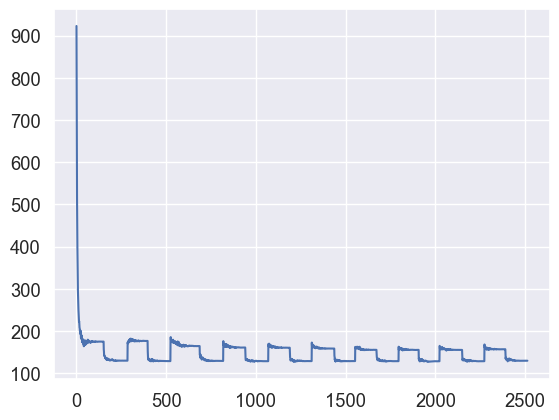

In [28]:
plt.plot(return_dict['eval_losses'])

In [22]:
encoder_params_dict, _ = DNN_LS.get_separate_params()

In [23]:
# optional: save trained model
import datetime
import os
import pickle


data = {'metadata':{'timestamp': str(datetime.datetime.now()),
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'batch_size': batch_size,
                    'input_dim': [EB095_input_dim, JAN23_input_dim],
                    'd_model': d_model,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'output_dim': [EB095_n_LS_neurons, JAN23_n_LS_neurons],
                    'n_layers': n_layers,
                    'num_epochs': num_epochs},
        'train_data': return_dict,
        'transformer_params': (encoder_params_dict, EB095_non_encoder_params_dict, JAN23_non_encoder_params_dict)}

with open(save_path / f'EB095-JAN23-transformer-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-transfer-learning-{n_iterations}.pkl', 'wb') as f:
    pickle.dump(data, f)